Author : Jamie Morton

__Problem__

We want - a graph dissimiliarity metric that can measure the distance between metabolite samples.

- If two samples have the exact same metabolites - distance is zero
- If two samples have no common metabolites - distance is very large

What if the two samples share some metabolites, but not all metabolites?

1. The unique metabolites have similiar structure
2. The metabolites have no similar structure

What is "similar structure"? What data types are involved?

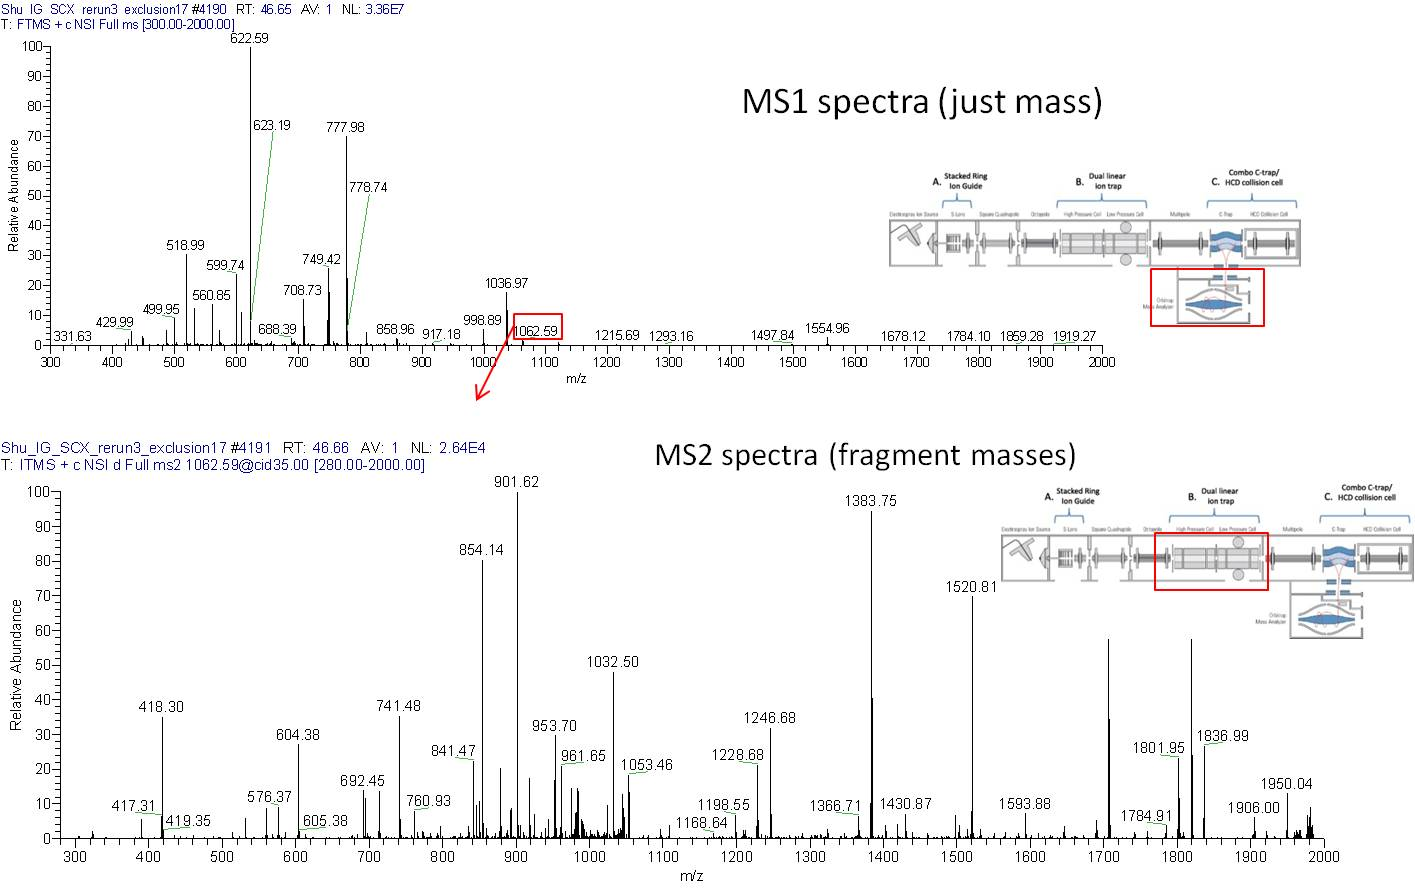

In [1]:
from IPython.display import Image
fig = Image(filename=('../figures/MS1_MS2.jpg'))
fig

The network is constructed through cosine dissimiliarities between metabolite spectra

- cosine disimiliarity of zero - the two metabolites are completely different
- cosine disimiliarity of one - the two metabolites are completely identical

Now, since we want to calculate the distance between two metabolomic sample, we'll want to use distances between metabolites, not similiarities.  A distance needs to be consistent with the following properties

1. $d(x, x) = 0$
2. $d(x, y) \geq 0$
3. $d(x, y) = d(y, x)$
4. $d(x, z) \leq d(x, y) + d(y, z)$

So for future reference, we won't be using cosine similiarity, we'll be using $d(i, j) = 1 - cos(i, j)$ as an estimate for the distance between metabolites $i$ and $j$.

Now, let's start enumerating some examples to get an idea about how we'd like this metric to behave.

In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import copy
from fractions import Fraction
from scipy.sparse import coo_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

We start by enumerate all possible combinations of a really simple network.
Each node corresponds to a metabolite, and each metabolite is colored by presence or absence within the red sample and the green sample.

- To the far left - sample red and sample green are identical
- To the far right - sample red and sample green are maximally distant

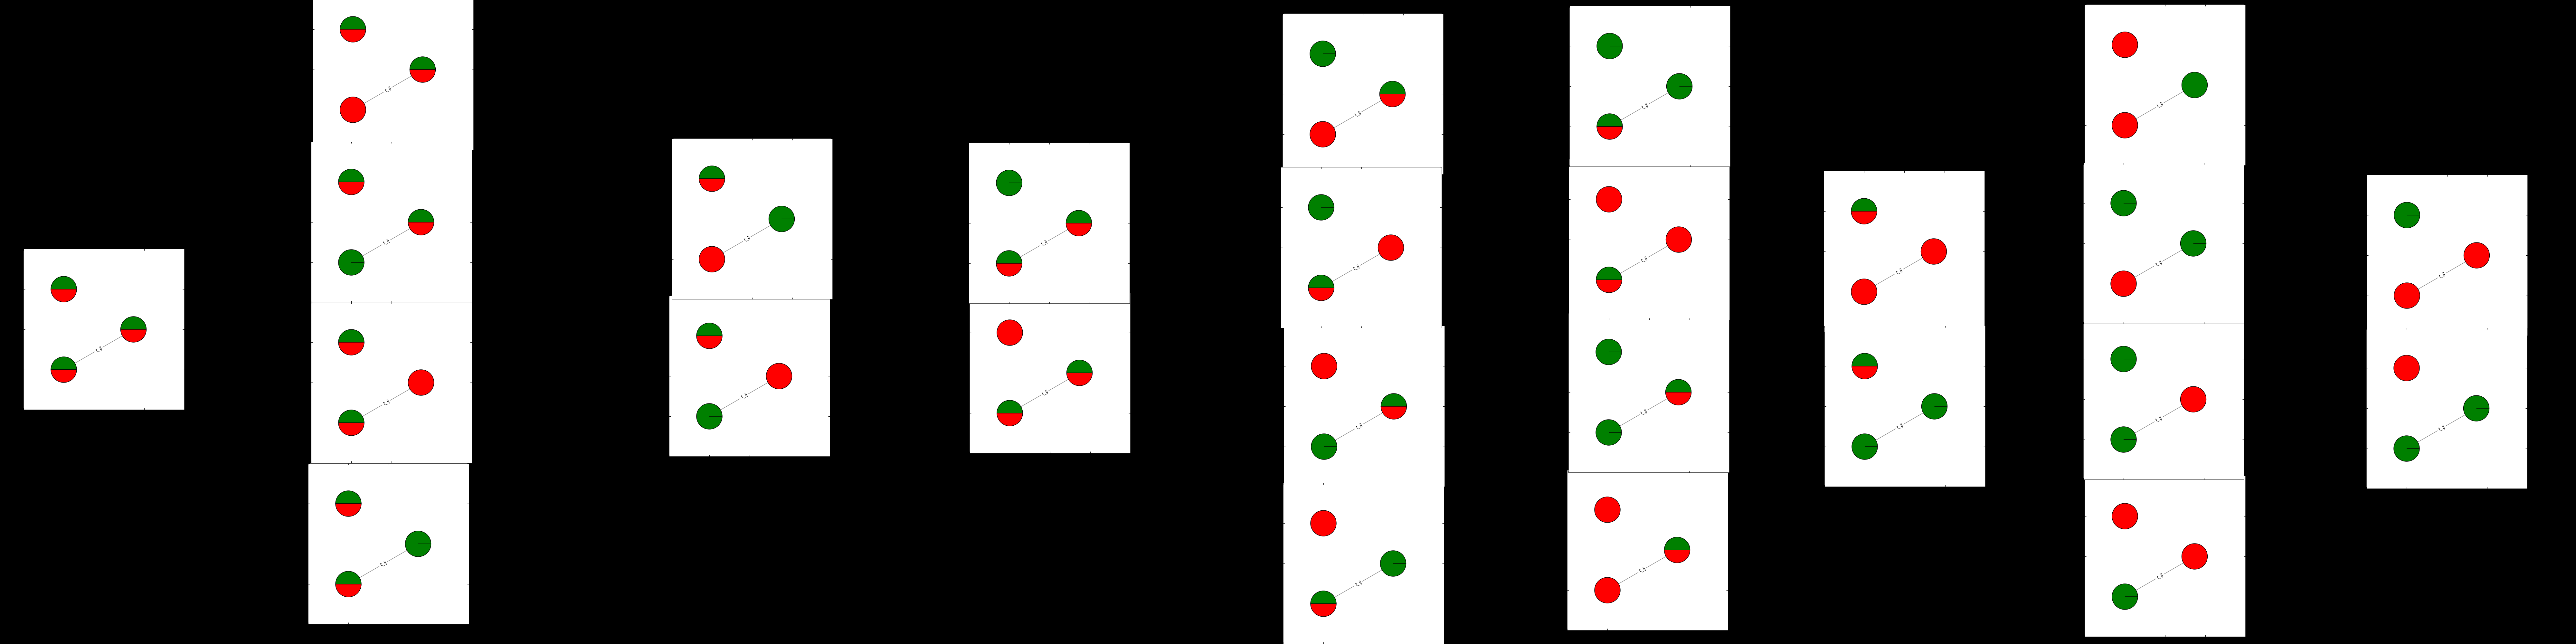

In [3]:
fig = Image(filename=('../figures/graph_order.png'))
fig

Intuitively, this should be the correct ordering.  How can we mathematically formulate the distance metric?

Try decomposing the metric into smaller steps namely

- Retraction - the process of "retracting" a metabolite in sample 1 to another metabolite in sample 2, if these metabolites are in the same similiarity network.
- Insertion - the process of "inserting" a completely new metabolite in sample 2 that is already present in sample 2
- Growth - the process of "growing" a metabolite in sample 1 to another metabolite in sample 2 if these metabolites are already present.

Note growth and retract are essentially analogous, it just makes for a cool name :)

If we can decompose the metric into these basic operations, then the distance between two metabolic similiarity networks would be the minimum number of operations required to transform one sample into the other.

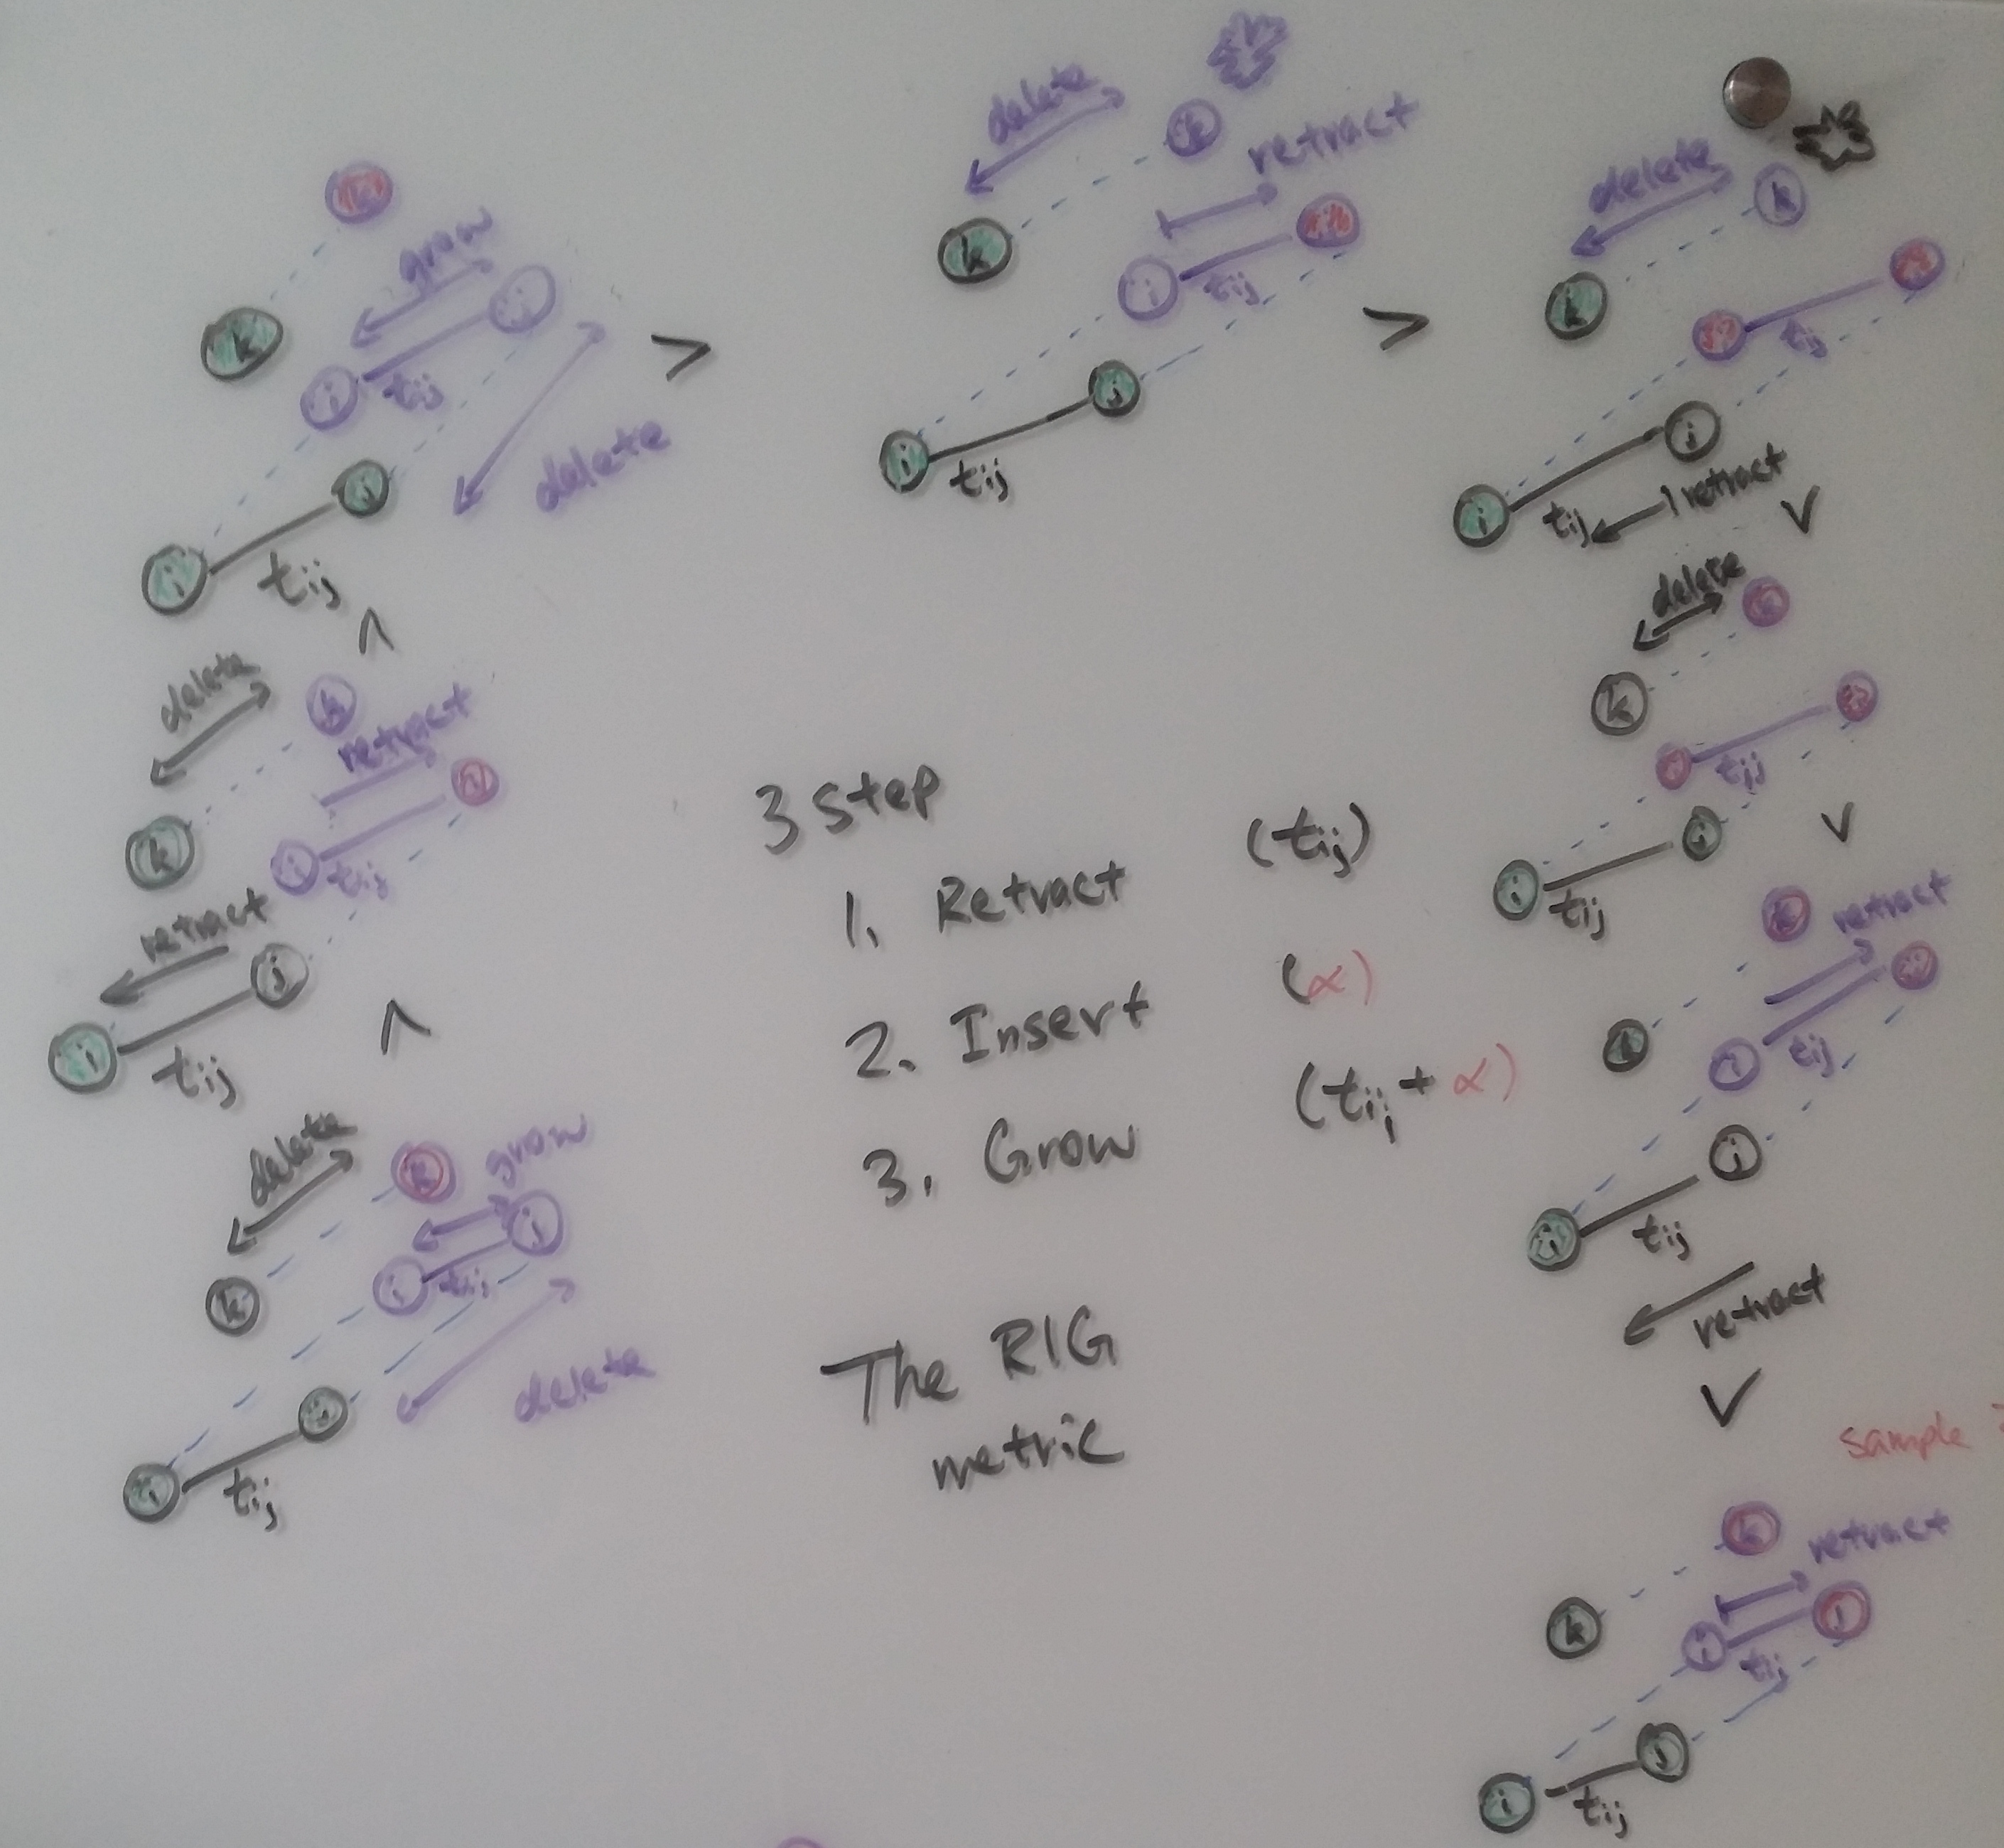

In [4]:
fig = Image(filename=('../figures/rig.png'))
fig

A few things to note

- Insertions have a larger weight compared to growth/retraction operations
- Multiple retraction operations are required to completely convert one metabolite into another
- Retraction/growth operations can be built on top of insertion operations.

Alrighty, how can we this scale up to large components?

Consider the mininum cost network flow problem - the cheapest way possible of sending flow through a flow network.

- Here, flow = metabolites
- And flow network = metabolite disimiliarities

Solving this problem will guarantee the mininum cost of transferring all of the metabolites from one sample into another sample.  This can be efficiently solved via the network simplex algorithm.

To better understand this problem, let's start drawing some graphs.

In [5]:
def draw_pretty_graph(G, x, y, xcolor='r', ycolor='g', pos=None):
    """ Draws pretty aligned graph
    
    Draws a pair of identical graphs with presence/absence information
    from sample x and sample y juxtaposed on each of them
    
    Parameters
    ----------
    G : nx.Graph
       Graph to be duplicated and drawn
    x : set
       Set of metabolites present in sample x
    y : set
       Set of metabolites present in sample y
    xcolor : str
       Color of the metabolites in sample x
    ycolor : str
       Color of the metabolites in sample y
    """
    Gx = copy.deepcopy(G)
    Gy = copy.deepcopy(G)
    alignedG = nx.union(Gx, Gy, rename=('x-','y-') )
    for node in G:
        alignedG.add_edge('x-%s' % node, 'y-%s' % node, {'weight': 0})
    if pos is None:
        pos = nx.spring_layout(alignedG) 
    
    nx.draw_networkx_nodes(alignedG, pos, 
                           nodelist=alignedG.nodes(), 
                           node_color='w',
                           node_size=700)
    nx.draw_networkx_edges(alignedG, pos, 
                           edgeslist=alignedG.edges(), 
                           node_color='k')

    nx.draw_networkx_nodes(alignedG, pos, 
                           nodelist=list(map(lambda t: 'x-%s' % t, x)), 
                           node_color=xcolor,
                           alpha=0.5,
                           node_size=700)
    nx.draw_networkx_edges(alignedG, pos, 
                           edgelist=list(map(lambda x: ('x-%s' % x[0], 'x-%s' % x[1]), Gx.edges())),
                           edge_color=xcolor, 
                           alpha=0.5, width=8)

    nx.draw_networkx_nodes(alignedG, pos, 
                           nodelist=list(map(lambda t: 'y-%s' % t, y)), 
                           node_color=ycolor,
                           alpha=0.5,
                           node_size=700)
    nx.draw_networkx_edges(alignedG, pos, 
                           edgelist=list(map(lambda x: ('y-%s' % x[0], 'y-%s' % x[1]), Gy.edges())), 
                           edge_color=ycolor,
                           alpha=0.5, width=8)
    nx.draw_networkx_labels(alignedG,pos,font_size=16)
    

Here, we have a single component with 3 metabolites, i, j and k.  The cosine distance between i and j is 0.8 and the cosine distance between j and k is 0.7.

{'i': <matplotlib.text.Text at 0x10b5931d0>,
 'j': <matplotlib.text.Text at 0x10b571da0>,
 'k': <matplotlib.text.Text at 0x10b57b828>}

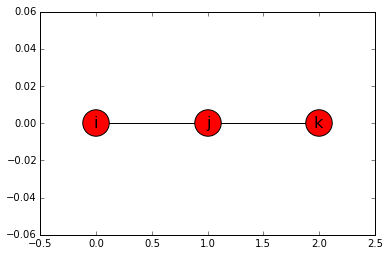

In [6]:
G = nx.Graph()
G.add_nodes_from(['i', 'j', 'k'])
G.add_edge('i','j', {'weight': 0.8})
G.add_edge('j','k', {'weight': 0.7})
pos = {'i':[0.,0.], 'j':[1.,0.], 'k':[2.,0.]}
nx.draw_networkx_nodes(G, pos, 
                       nodelist=G.nodes(),
                       node_size=700)
nx.draw_networkx_edges(G, pos, 
                       edgelist=G.edges())
nx.draw_networkx_labels(G, pos, font_size=16)

Now imagine, in sample x only metabolites i and j are present and in sample y, all 3 of these metabolites are present. For the sake of easier visualization, we'll duplicate this graph and juxtapose sample x and sample y on different copies of the graph.

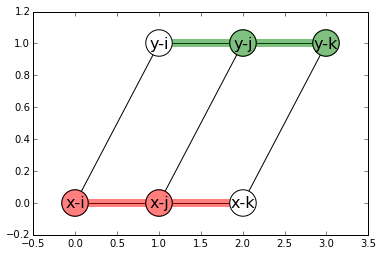

In [7]:
pos = {'x-i':[0.,0.], 'x-j':[1.,0.], 'x-k':[2.,0.],
       'y-i':[1.,1.], 'y-j':[2.,1.], 'y-k':[3.,1.]}
draw_pretty_graph(G, x={'i', 'j'}, y={'j','k'}, pos=pos)

Intuitively, it should only take 2 steps to transform sample x into sample y.

But if we wanted to use the network simplex algorithm, we need to add an additional parameter.
Every node must have a `demand` variable set.  For the purpose of our datasets, we can encode the `demand` variable with abundance information.

- metabolites present in one of the samples will have a positive demand
- metabolites absent in one sample but present in the other will have a negative demand
- metabolites present in neither sample will have zero demand

One minor challenge is that the sum of all of the demands needs to be zero.  
This can be remedied by normalizing all of the metabolite abundances within a component within in each sample to sum to 1.

To better understand this in the context of the graph above, since only metabolites i and j were observed in sample x, each of those demands needs to be $\frac{1}{2}$.  And the demands for sample y needs to be $\frac{1}{2}$.

But remember that the sum of the demands must be zero.  And since metabolite i isn't present in sample x, but it is present in sample y, it must have a demand of $-1$ (i.e. cannot create flow between the two copies of the graph).
So `y-i` and `x-k` will have a demand of $-1$.

Once we add in the demand variables, then it is ready to be plugged into the network simplex algorithm.

__But we are not done__

What sample x is a complete subset of sample y?
Consider the following graph.

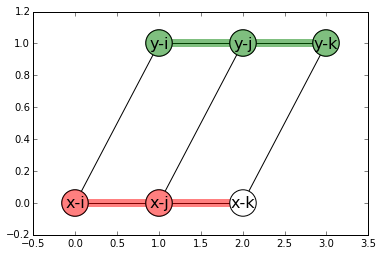

In [8]:
G = nx.Graph()
G.add_nodes_from(['i', 'j', 'k'])
G.add_edge('i','j', {'weight': 1})
G.add_edge('j','k', {'weight': 10})
pos = {'x-i':[0.,0.], 'x-j':[1.,0.], 'x-k':[2.,0.],
       'y-i':[1.,1.], 'y-j':[2.,1.], 'y-k':[3.,1.]}
draw_pretty_graph(G, x={'i', 'j'}, y={'i','j','k'}, pos=pos)

Now if we continue assigning demands to the metabolites that are present, then we are stuck with a scenario where the sum of the demands positive.

Following this line of thought, none of the demands in sample y should be positive.  The only possible flow can only occur in sample x.

So the correct solution in this scenerio is, completely ignore sample y.

Now, we can categorize this into two possible scenarios.

 1. The two samples are none overlapping.
 2. One of the samples is a subset of the other. 
 
Then we can assign demands to each variable according to these two scenarios.

In [9]:
def _subsetted_graph(G, x, y):
    """ Finds mininum flow cover in the scenario where x is a subset of y

    This is a special case of path cover finding the minimum weighted path
    cover linking sample x and sample y.  Ultimately, this boils down to the
    mininum flow problem, which can be solved via network simplex algorithm.

    Parameters
    ----------
    G : nx.Graph
       A connected graph of weighted edges
    x : list, str
       Set of nodes present in sample x.  x is a subset of y
    y : list, str
       Set of nodes present in sample y.  y is a superset of x

    Returns
    -------
    cost : float
       Minimum flow cost

    """
    xtotal = len(x)
    missing_total = len(y - x)
    inX, outX = x, y - x
    newG = copy.deepcopy(G)
    for node in G.nodes():
        
        if node in inX:
            newG.node[node]['demand'] = Fraction(1, xtotal)
        else:
            newG.node[node]['demand'] = Fraction(-1, missing_total)
    
    cost, _ = nx.network_simplex(newG.to_directed())
    return cost


In [10]:
def _non_subsetted_graph(G, x, y):
    """ Finds mininum flow cover in the scenario where x is not a subset of y

    This is a special case of path cover finding the minimum weighted path
    cover linking sample x and sample y.  Ultimately, this boils down to the
    mininum flow problem, which can be solved via network simplex algorithm.

    Parameters
    ----------
    G : nx.Graph
       A connected graph of weighted edges
    x : list, str
       Set of nodes present in sample x.  x is a subset of y.
    y : list, str
       Set of nodes present in sample y.  y is a superset of x.

    Returns
    -------
    cost : float
       Minimum flow cost
    """
    Gx = copy.deepcopy(G)
    Gy = copy.deepcopy(G)
    num_shared = len(x & y)
    num_uniquex = len(x - y)
    num_uniquey = len(y - x)
    xtotal = len(x)
    ytotal = len(y)
    for node in G.nodes():
        if node in x and node not in y:
            Gx.node[node]['demand'] = Fraction(1, xtotal)
            Gy.node[node]['demand'] = Fraction(-1, num_uniquex)
        elif node not in x and node in y:
            Gx.node[node]['demand'] = Fraction(-1, num_uniquey)
            Gy.node[node]['demand'] = Fraction(1, ytotal)
        elif node in x and node in y:
            Gx.node[node]['demand'] = Fraction(1, xtotal)
            Gy.node[node]['demand'] = Fraction(1, ytotal)
        else:
            Gx.node[node]['demand'] = 0
            Gy.node[node]['demand'] = 0
    costx, _ = nx.network_simplex(Gx.to_directed())
    costy, _ = nx.network_simplex(Gy.to_directed())
    cost = costx + costy
    return cost

And once we've set the demands, we can plug this into the network simplex algorithm.  We'll refer to this step as the ___retract step___.

Now, the retract step explicitly assumes that sample x and sample y have metabolites within the component.
See below for an example.

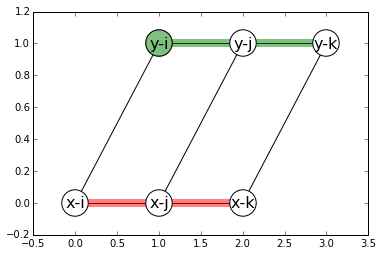

In [11]:
G = nx.Graph()
G.add_nodes_from(['i', 'j', 'k'])
G.add_edge('i','j', {'weight': 1})
G.add_edge('j','k', {'weight': 10})
pos = {'x-i':[0.,0.], 'x-j':[1.,0.], 'x-k':[2.,0.],
       'y-i':[1.,1.], 'y-j':[2.,1.], 'y-k':[3.,1.]}
draw_pretty_graph(G, x={}, y={'i'}, pos=pos)

And there is really no good answer on how to handle this scenario.

But there is one property that we must guarantee.  We must guarantee that when x is missing metabolites, the distance between x and y must be larger compared to all possible configurations when both x and y have present metabolites.

A sure fire way to do this is to inflate this distance by a very large value. We can set this very large value to be the sum of edges within the largest component.  We'll refer to this inflation as the ___insert step___.  This is because this artifical inflation would be the cost of articifially introducing a completely new metabolite into sample x.  And no distance between sample x and sample y can exceed this threshold if metabolites in sample x and sample y are both present in the component.

Biologically, this makes no sense, but it allows us to mathematically differientiate between the scenarios when x is absent and when x is present.

Another issue that will pop up is figuring out how to differientiate between different scenarios when sample x is completely missing metabolites.  In other words, the below scenario should have a larger distance than the above scenario.

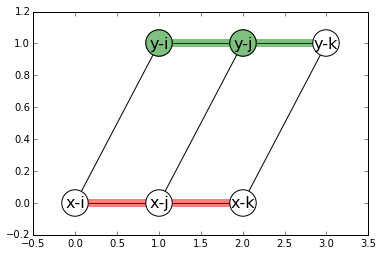

In [12]:
G = nx.Graph()
G.add_nodes_from(['i', 'j', 'k'])
G.add_edge('i','j', {'weight': 1})
G.add_edge('j','k', {'weight': 10})
pos = {'x-i':[0.,0.], 'x-j':[1.,0.], 'x-k':[2.,0.],
       'y-i':[1.,1.], 'y-j':[2.,1.], 'y-k':[3.,1.]}
draw_pretty_graph(G, x={}, y={'i', 'j'}, pos=pos)

A quick fix to this issue is to introduce an artificial metabolite and re-apply the retract step.  We'll refer to this as the ___growth step___.  We can artifically introduce metabolite i after inflating the distance.  Note that we only want to insert metabolites in sample x that are already present in sample y (i.e. can't insert metabolite k).

Now, it isn't clear what the best why to re-apply the retract step is.  For now, we'll just add the additional retract/growth cost to the insertion cost.

In [13]:
def rig_component(G, x, y, maxW):
    """ Compute the RIG metric on a single component.

    Parameters
    ----------
    G : nx.Graph
       A connected graph of weighted edges
    x : list, str
       Set of nodes present in sample x
    y : list, str
       Set of nodes present in sample y
    maxW : float
       The cost of an insertion step
       
    Returns
    -------
    float :
       Distance between sample x and sample y

    Note
    ----
    If x or y is None, then 1 will be added to the total distance.
    If they are both None, then the distance will be zero.
    Also, the weights of the edges must be contained in `'weight'`.
    """
    # Both samples don't contain any metabolites
    if len(x)==0 and len(y)==0:
        return 0
    
    # Both samples contains the exact same metabolites
    # Note that this will change once we start adding weights
    # due to abundance.
    if x == y:
        return 0
    
    # The component being analyzed has only 1 node.
    # So the networkx simplex algorithm cannot be run
    # since there are no edges.
    if len(G.nodes()) == 1:
        return maxW
    
    cost = 0
    edges = G.edges(data='weight')        
    
    # If there one of the samples doesn't have any metabolites
    # on the component, arbituarily pick two metabolites
    # and append them to the set.  This to address the issue of
    # measuring distance between unshared components.
    if len(x) == 0:
        x = {list(y)[0]}
        weight = maxW
    elif len(y) == 0:
        y = {list(x)[0]}
        weight = maxW
    else:
        weight = 0

    _G = copy.deepcopy(G)
    num_shared = len(x & y)
    num_uniquex = len(x - y)
    num_uniquey = len(y - x)
    xtotal = len(x)
    ytotal = len(y)

    xarr = {n : Fraction((n in x), xtotal) for n in G.nodes()}
    yarr = {n : Fraction((n in y), ytotal) for n in G.nodes()}
        
    for node in _G.nodes():
        _G.node[node]['demand'] = xarr[node] - yarr[node]
    W, _ = nx.network_simplex(_G.to_directed())
 
    cost += W + weight
    return cost

Okay, we have defined the distance metric to a single component.

Now, we can just apply this metric to all components and add them together.

In [14]:
def rig(G, x, y, res=1e-9):
    """ Compute the RIG metric on all components.

    Parameters
    ----------
    G : nx.Graph
       A connected graph of weighted edges
    x : list, str
       Set of nodes present in sample x
    y : list, str
       Set of nodes present in sample y

    Returns
    -------
    float :
       Distance between sample x and sample y

    Note
    ----
    If x or y is None, then 1 will be added to the total distance.
    If they are both None, then the distance will be zero.

    """
    cost = 0
    _G = copy.deepcopy(G)
    # This converts all of the weights to integers
    for u,v,d in _G.edges(data=True):
        d['weight'] = int(d['weight'] / res)
    
    # This calculates the largest edge set to offset the insertion cost.
    weights = []
    for comp in nx.connected_component_subgraphs(_G):
        edges = comp.edges(data='weight')
        if len(edges) > 0:
            weights.append(sum(list(zip(*edges))[2]))
    maxW = max(weights) + 1
        
    for comp in nx.connected_component_subgraphs(_G):
        nodes = set(comp.nodes())
        c = rig_component(comp, x & nodes, y & nodes, maxW)
        cost += c
    return np.log(float(cost)*res + 1)

Alrighty, now lets try to apply this to all of the possible scenarios that we initially enumerated

In [15]:
G = nx.Graph()
G.add_nodes_from(['i', 'j', 'k'])

G.add_edge('i','j', {'weight': 0.9})
print('Scenario 1: distance =', rig(G, {'i', 'j', 'k'}, {'i', 'j', 'k'}))
print('Scenario 2: distance =', rig(G, {'j', 'k'}, {'i', 'j', 'k'}))
print('Scenario 3: distance =', rig(G, {'j', 'k'}, {'i', 'k'}))
print('Scenario 4: distance =', rig(G, {'i', 'j'}, {'i', 'j', 'k'}))
print('Scenario 5: distance =', rig(G, {'i', 'k'}, {'i', 'j'}))
print('Scenario 6: distance =', rig(G, {'i', 'j', 'k'}, {'j'}))
print('Scenario 7: distance =', rig(G, {'i', 'j', 'k'}, {'k'}))
print('Scenario 8: distance =', rig(G, {'i', 'k'}, {'j'}))
print('Scenario 9: distance =', rig(G, {'i', 'j'}, {'k'}))


Scenario 1: distance = 0.0
Scenario 2: distance = 0.371563556432
Scenario 3: distance = 0.641853886172
Scenario 4: distance = 0.641853886699
Scenario 5: distance = 0.854415328582
Scenario 6: distance = 0.854415328582
Scenario 7: distance = 0.854415328582
Scenario 8: distance = 1.02961941754
Scenario 9: distance = 1.17865499696


__Questions__

1. Would it be worthwhile to scale the retract/growth step after insertion? That way we can give more weight to the growth step. (And would allow us to swap Scenarios 7 and 8).
2. How can we differientiate between Scenarios 5, 6, 7?

__In Conclusion__

We aren't quite done
- Cannot handle floats in demands [issue # 1846](https://github.com/networkx/networkx/issues/1846)
- Cannot handle floats in edge weights [issue #1858](https://github.com/networkx/networkx/issues/1858)
- Need more large component scenarios (very tricky to enumerate).
- Need to think about insertion cost.
- Need to think about growth cost after insertion.

__References__

- [Original network simplex paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.297.5260&rep=rep1&type=pdf)
- [Follow up network simplex paper](http://jorlin.scripts.mit.edu/docs/publications/55-polynomial%20time%20primal.pdf)  
- [Minimum cover](https://en.wikipedia.org/wiki/Edge_cover)

___Below___

Counter examples

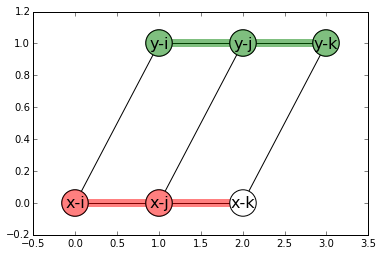

In [16]:
G = nx.Graph()
G.add_nodes_from(['i', 'j', 'k'])
G.add_edge('i','j', {'weight': 1})
G.add_edge('j','k', {'weight': 10})
pos = {'x-i':[0.,0.], 'x-j':[1.,0.], 'x-k':[2.,0.],
       'y-i':[1.,1.], 'y-j':[2.,1.], 'y-k':[3.,1.]}
draw_pretty_graph(G, x={'i','j'}, y={'i', 'j', 'k'}, pos=pos)

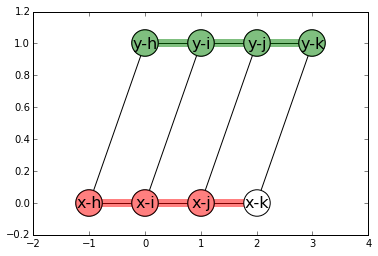

In [17]:
Gn = nx.Graph()
Gn.add_nodes_from(['i', 'j', 'k', 'h'])
Gn.add_edge('i','j', {'weight': 1})
Gn.add_edge('j','k', {'weight': 10})
Gn.add_edge('i','h', {'weight': 20})
pos = {'x-i':[0.,0.], 'x-j':[1.,0.], 'x-k':[2.,0.], 'x-h':[-1.,0.],
       'y-i':[1.,1.], 'y-j':[2.,1.], 'y-k':[3.,1.], 'y-h':[0.,1.],}
draw_pretty_graph(Gn, x={'i', 'j', 'h'}, y={'j','i', 'k', 'h'}, pos=pos)

In [18]:
print('Scenario G: distance =', float(rig(G, {'i', 'j', 'k'}, {'i', 'j'})))
print('Scenario Gn: distance =', float(rig(Gn, {'i', 'j', 'h'}, {'j', 'k', 'h'})))

Scenario G: distance = 1.5040773967392371
Scenario Gn: distance = 1.5404450408757204


Now, let's read some coral data

In [19]:
meta_file = 'coral_meta.txt'
xls_file = '../data/Coral_ChemiFRAC_test.xlsx'

table = pd.read_excel(xls_file, sheetname=1, index_col=0).T
edges = pd.read_excel(xls_file, sheetname=0)
maxID = max([edges['CLUSTERID1'].max(), edges['CLUSTERID2'].max()]) + 1
spm = coo_matrix((edges['Cosine'].values, 
                  (edges['CLUSTERID1'].values, 
                   edges['CLUSTERID2'].values)),
                shape=(maxID, maxID))
coral_nwk = nx.from_scipy_sparse_matrix(spm)
meta_map = pd.read_table('../data/%s' % meta_file) 

In [20]:
p = meta_map.loc[meta_map['Organism'] == 'Porites', :]
b = meta_map.loc[meta_map['Organism'] == 'Black Nasty', :]
small_map = pd.concat([p, b])
idx = [x in set(small_map['#SampleID'].values) for x in table.index]
small_table = table.loc[idx, :]

In [ ]:
dm = pd.DataFrame(columns=small_map.index,
                  index=small_map.index)
for i in range(len(small_map.index)):
    for j in range(i):
        sampIDs = small_map['#SampleID'].values
        _x, _y = sampIDs[i], sampIDs[j]
        
        x_idx = (small_table.loc[_x, :] > 0).values
        y_idx = (small_table.loc[_y, :] > 0).values
        x = set(small_table.loc[_x, x_idx].index)
        y = set(small_table.loc[_y, y_idx].index)
        dm.loc[_x, _y] = rig(coral_nwk, set(x), set(y))
        print(i, j, dm.loc[_x, _y])

In [ ]:
dm.to_csv('../results/rig.txt')